Tic Tac Toe Spielstanderkenner

Ziel dieser Arbeit ist es, dass Bilder eines Tic Tac Toe Spiels eingegeben werden und der Spielstand automatisch erkannt wird. Wenn es einen Gewinner gibt, soll dieser Markiert und ausgegeben werden

Schritt 1 Bilder einlesen

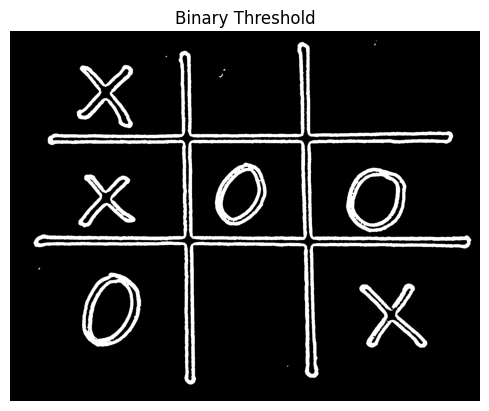

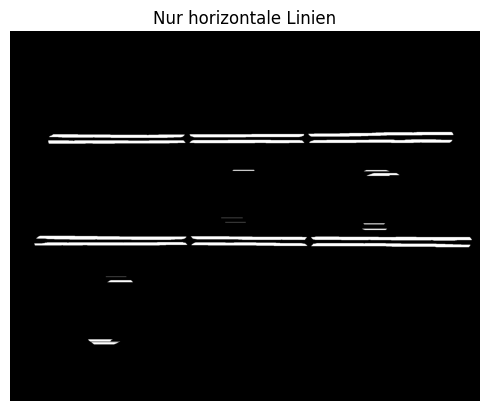

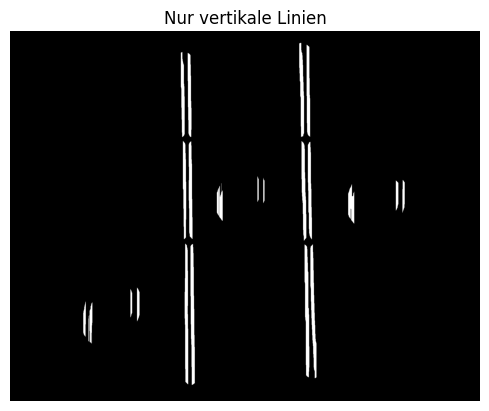

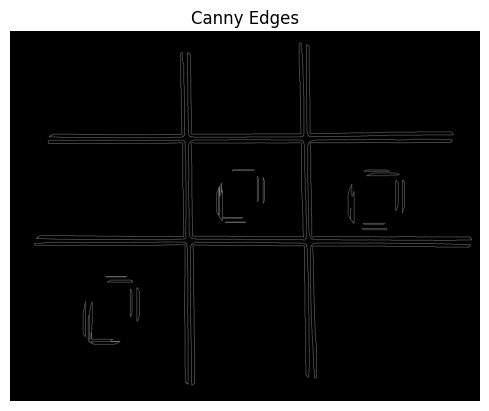

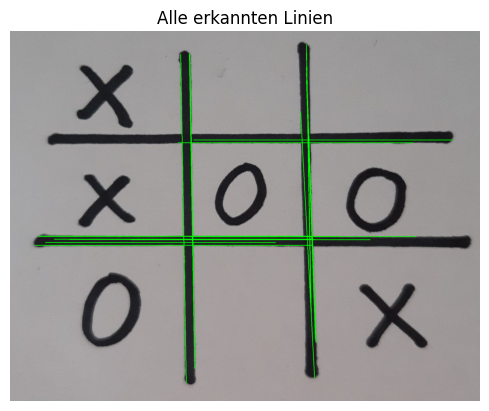

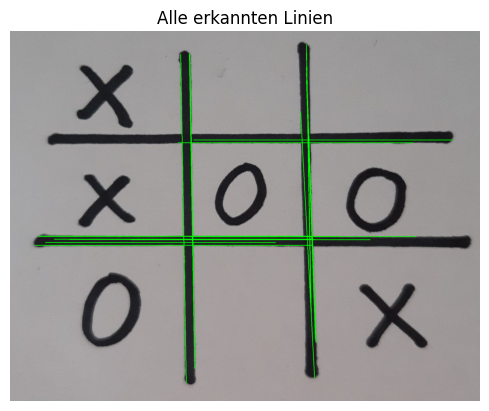

x-ungeclustert: [np.int32(684), np.int32(717), np.int32(718), np.int32(1188), np.int32(1178), np.int32(1187), np.int32(1173), np.int32(1186), np.int32(1177), np.int32(716)]
x-geclustert: [708, 1181]
y-ungeclustert: [np.int32(809), np.int32(844), np.int32(808), np.int32(820), np.int32(429), np.int32(821), np.int32(822), np.int32(440), np.int32(833), np.int32(810)]
y-geclustert: [434, 820]


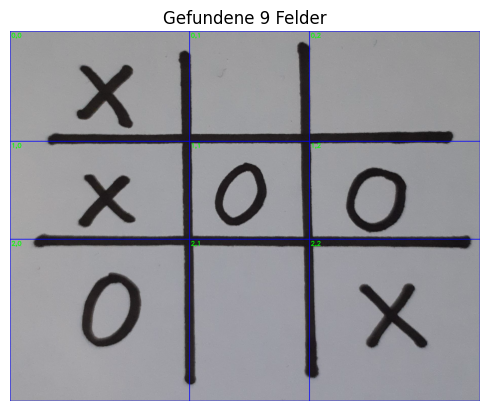

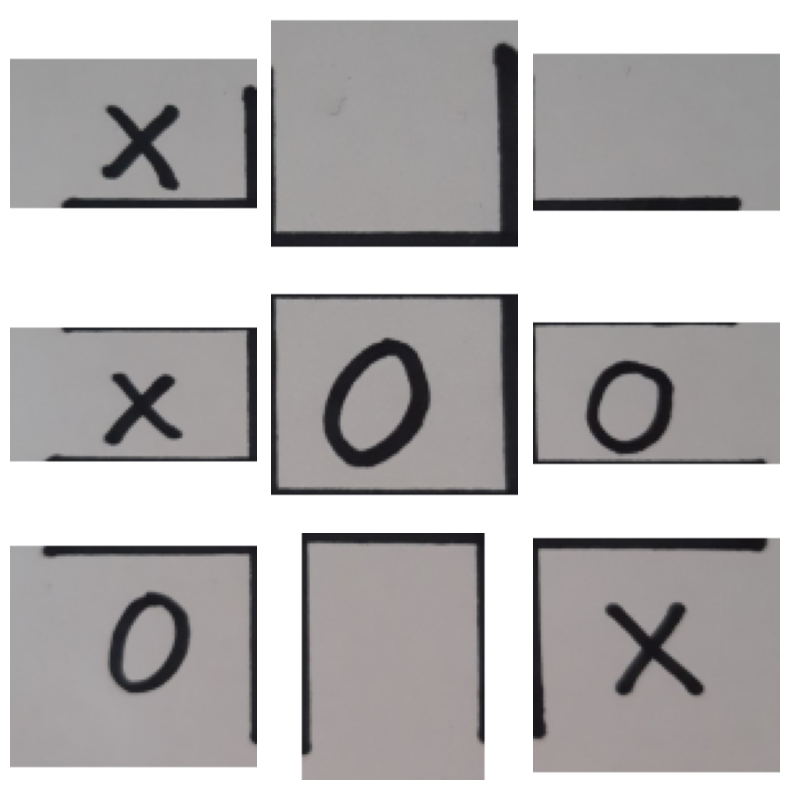

In [227]:
import math
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import color

def show_image(image, title=None):
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def cluster_coords(coords, mindist=20):
    if not coords:
        return []
    coords = sorted(coords)
    clustered = []
    current = [coords[0]]
    for c in coords[1:]:
        if abs(c - current[-1]) < mindist:
            current.append(c)
        else:
            clustered.append(int(np.mean(current)))
            current = [c]
    clustered.append(int(np.mean(current)))
    return clustered

def get_two_most_centered(coords, img_size):
    if len(coords) < 2:
        return [img_size//3, 2*img_size//3]  # Fallback: mittig geschätzt
    targets = [img_size//3, 2*img_size//3]
    selected = []
    coords = sorted(coords)
    for t in targets:
        best = min(coords, key=lambda c: abs(c - t))
        selected.append(best)
        coords.remove(best)
    return sorted(selected)

def get_line_centers(lines, img_size, axis='x'):
    coords = []
    if lines is not None:
        for l in lines:
            x1,y1,x2,y2 = l[0]
            if axis=='x' and abs(x1-x2) < img_size*0.15:
                coords.append((x1+x2)//2)
            if axis=='y' and abs(y1-y2) < img_size*0.15:
                coords.append((y1+y2)//2)
    mind = 15 if axis=='y' else int(img_size*0.04)
    clustered = cluster_coords(coords, mindist=mind)
    print(f"{axis}-ungeclustert:", coords)
    print(f"{axis}-geclustert:", clustered)
    return clustered

def filter_longest_lines(lines, num=12):
    if lines is None or len(lines)==0:
        return []
    segs = [l[0] for l in lines]
    segs.sort(key=lambda l:(l[2]-l[0])**2+(l[3]-l[1])**2, reverse=True)
    return np.array([[s] for s in segs[:num]])

def crop_to_largest_contour(binary, img):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return binary, img
    x,y,w,h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    pad = int(0.04 * max(w,h))
    x,y = max(0,x-pad), max(0,y-pad)
    w,h = min(binary.shape[1]-x, w+2*pad), min(binary.shape[0]-y, h+2*pad)
    return binary[y:y+h, x:x+w], img[y:y+h, x:x+w]

def extract_grid_lines(binary):
    """ Extrahiert horizontale und vertikale Linien separat. """
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))

    detect_horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    detect_vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    return detect_horizontal, detect_vertical


def detect_tic_tac_toe_grid(img_path):
    if os.path.exists(img_path):
        img_orig = cv2.imread(img_path)
    else:
        raise FileNotFoundError(f"Bilddatei '{img_path}' nicht gefunden.")
    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

    blur = cv2.medianBlur(gray, 7)

    # adaptive threshold
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=51, C=7
    )
    show_image(binary, "Binary Threshold")

    # gerichtete Linienextraktion
    grid_h, grid_v = extract_grid_lines(binary)
    show_image(grid_h, "Nur horizontale Linien")
    show_image(grid_v, "Nur vertikale Linien")

    # combine für Kantendetektion
    grid_combined = cv2.bitwise_or(grid_h, grid_v)

    h, w = binary.shape
    edges = cv2.Canny(grid_combined, 20, 70, apertureSize=3)
    show_image(edges, "Canny Edges")

    min_dim = min(h,w)
    minL = int(min_dim*0.1)
    maxG= int(min_dim*0.25)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi/180,
        threshold=10, minLineLength=minL, maxLineGap=maxG
    )
    lines = filter_longest_lines(lines, num=20)

    if lines is not None and len(lines):
        dbg = img_orig.copy()
        for l in lines:
            x1,y1,x2,y2 = l[0]
            cv2.line(dbg, (x1,y1), (x2,y2), (0,255,0), 2)
        show_image(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB), "Alle erkannten Linien")

    if lines is not None and len(lines):
        dbg = img_orig.copy()
        for l in lines:
            x1,y1,x2,y2 = l[0]
            cv2.line(dbg, (x1,y1), (x2,y2), (0,255,0), 2)
        show_image(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB), "Alle erkannten Linien")

    x_centers = get_line_centers(lines, w, axis='x')
    y_centers = get_line_centers(lines, h, axis='y')
    vx = get_two_most_centered(x_centers, w)
    hy = get_two_most_centered(y_centers, h)

    x_coords = [0] + vx + [w]
    y_coords = [0] + hy + [h]

    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_grid = img_rgb.copy()
    field_bilder, positionen = [], []

    for row in range(3):
        for col in range(3):
            xa, xb = x_coords[col], x_coords[col+1]
            ya, yb = y_coords[row], y_coords[row+1]
            feld = img_orig[ya:yb, xa:xb]
            field_bilder.append(feld)
            positionen.append((row, col))
            cv2.rectangle(img_grid, (xa,ya), (xb,yb), (255,0,0), 2)
            cv2.putText(img_grid, f"{row},{col}", (xa+5, ya+25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    show_image(cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB), "Gefundene 9 Felder")
    return field_bilder, positionen

def crop_and_resize_field(field_img, size=96, pad_color=(255,255,255)):
    h,w = field_img.shape[:2]
    scale = size / max(h,w)
    nh,nw = int(h*scale), int(w*scale)
    resized = cv2.resize(field_img, (nw,nh), interpolation=cv2.INTER_AREA)
    canvas = np.full((size,size,3), pad_color, dtype=np.uint8)
    ys, xs = (size-nh)//2, (size-nw)//2
    canvas[ys:ys+nh, xs:xs+nw] = resized
    return canvas

def show_9_fields(field_bilder, positionen, size=96):
    fig, axs = plt.subplots(3,3, figsize=(8,8))
    for img_cell,(r,c) in zip(field_bilder, positionen):
        norm = crop_and_resize_field(img_cell, size)
        axs[r,c].imshow(cv2.cvtColor(norm, cv2.COLOR_BGR2RGB))
        axs[r,c].axis('off')
    plt.tight_layout()
    plt.show()

# Beispiel-Aufruf
#field_bilder, positionen = detect_tic_tac_toe_grid('Test_Fabi/Filled_Field2.png') 
field_bilder, positionen = detect_tic_tac_toe_grid('Test_Wiebke/feld_3.jpg')
show_9_fields(field_bilder, positionen)


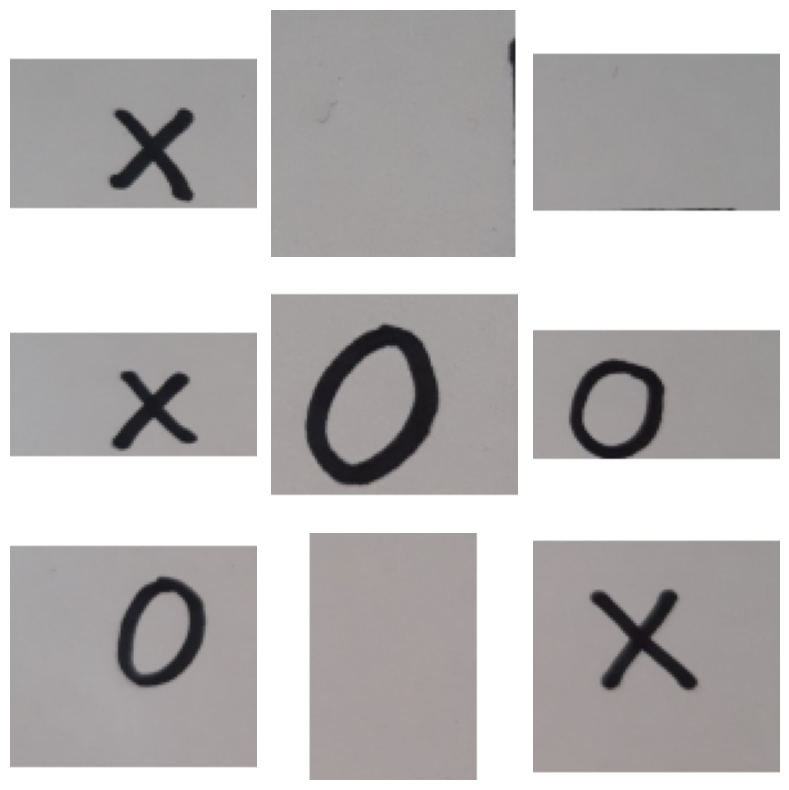

In [228]:
def cut(img, sides, amount_percent=8):
    h, w = img.shape[:2]
    
    amount_h = int(h * amount_percent / 100)
    amount_w = int(w * amount_percent / 100)

    top = amount_h if 'top' in sides else 0
    bottom = h - amount_h if 'bottom' in sides else h
    left = amount_w if 'left' in sides else 0
    right = w - amount_w if 'right' in sides else w

    return img[top:bottom, left:right]

    
new_field_bilder = []

for img_cell,(r,c) in zip(field_bilder, positionen):
    match (r, c):
        case (0, 0):
            img_cell = cut(img_cell, ('bottom', 'right'))
        case (0, 1):
            img_cell = cut(img_cell, ('bottom', 'right', 'left'))
        case (0, 2):
            img_cell = cut(img_cell, ('bottom', 'left'))
        case (1, 0):
            img_cell = cut(img_cell, ('top', 'bottom', 'right'))
        case (1, 1):
            img_cell = cut(img_cell, ('top', 'bottom', 'right', 'left'), amount_percent=10)
        case (1, 2):
            img_cell = cut(img_cell, ('top', 'bottom', 'left'))
        case (2, 0):
            img_cell = cut(img_cell, ('top', 'right'))
        case (2, 1):
            img_cell = cut(img_cell, ('top', 'right', 'left'))
        case (2, 2):
            img_cell = cut(img_cell, ('top', 'left'))
    new_field_bilder.append(img_cell)

field_bilder = new_field_bilder

            
show_9_fields(field_bilder, positionen)

In [229]:
def extract_straight_lines_from_image(img, show=True):
    """
    Extrahiert horizontale und vertikale Linien aus einem Bild.
    Gibt zurück: horizontale Maske, vertikale Maske, Anzahl horizontale Linien, Anzahl vertikale Linien
    """
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    blur = cv2.medianBlur(gray, 7)
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=51, C=7
    )

    if show:
        show_image(binary, "Binärbild")

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))

    detect_horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    detect_vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=2)


    # Kanten und Linien zählen
    edges_h = cv2.Canny(detect_horizontal, 50, 150, apertureSize=3)
    edges_v = cv2.Canny(detect_vertical, 50, 150, apertureSize=3)

    lines_h = cv2.HoughLinesP(edges_h, 1, np.pi/180, threshold=30, minLineLength=30, maxLineGap=10)
    lines_v = cv2.HoughLinesP(edges_v, 1, np.pi/180, threshold=30, minLineLength=30, maxLineGap=10)

    num_h = len(lines_h) if lines_h is not None else 0
    num_v = len(lines_v) if lines_v is not None else 0
    
    if show:
        show_image(detect_horizontal, "Horizontale Linien")
        show_image(detect_vertical, "Vertikale Linien")
        combined = cv2.bitwise_or(detect_horizontal, detect_vertical)
        show_image(combined, "Kombinierte Linien (H+V)")
        print(f"Anzahl horizontale Linien: {num_h}, vertikale Linien: {num_v}")

   
    

    return detect_horizontal, detect_vertical, num_h, num_v


def extract_diagonal_lines_from_image(img, show=True):
    """
    Extrahiert diagonale Linien (↘ und ↙) aus einem Bild.
    Gibt zurück: Maske ↘, Maske ↙, Anzahl Linien ↘, Anzahl Linien ↙
    """
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    blur = cv2.medianBlur(gray, 7)
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=51, C=7
    )

    if show:
        show_image(binary, "Binärbild")

    h, w = binary.shape
    center = (w // 2, h // 2)
    angle = 45

    # ↘ Richtung
    M1 = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated1 = cv2.warpAffine(binary, M1, (w, h), flags=cv2.INTER_NEAREST)
    kernel_diag1 = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    diag1 = cv2.morphologyEx(rotated1, cv2.MORPH_OPEN, kernel_diag1, iterations=2)
    M1_inv = cv2.getRotationMatrix2D(center, angle, 1.0)
    diag1_unrot = cv2.warpAffine(diag1, M1_inv, (w, h), flags=cv2.INTER_NEAREST)

    # ↙ Richtung
    M2 = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated2 = cv2.warpAffine(binary, M2, (w, h), flags=cv2.INTER_NEAREST)
    kernel_diag2 = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
    diag2 = cv2.morphologyEx(rotated2, cv2.MORPH_OPEN, kernel_diag2, iterations=2)
    M2_inv = cv2.getRotationMatrix2D(center, -angle, 1.0)
    diag2_unrot = cv2.warpAffine(diag2, M2_inv, (w, h), flags=cv2.INTER_NEAREST)


    # Linien zählen
    edges1 = cv2.Canny(diag1_unrot, 50, 150, apertureSize=3)
    edges2 = cv2.Canny(diag2_unrot, 50, 150, apertureSize=3)

    lines1 = cv2.HoughLinesP(edges1, 1, np.pi/180, threshold=30, minLineLength=30, maxLineGap=10)
    lines2 = cv2.HoughLinesP(edges2, 1, np.pi/180, threshold=30, minLineLength=30, maxLineGap=10)

    num_d1 = len(lines1) if lines1 is not None else 0
    num_d2 = len(lines2) if lines2 is not None else 0
    
    if show:
        show_image(diag1_unrot, "Diagonale Linien ↘")
        show_image(diag2_unrot, "Diagonale Linien ↙")
        combined = cv2.bitwise_or(diag1_unrot, diag2_unrot)
        show_image(combined, "Kombinierte diagonale Linien")
        print(f"Anzahl diagonale Linien ↘: {num_d1}, ↙: {num_d2}")

    return diag1_unrot, diag2_unrot, num_d1, num_d2




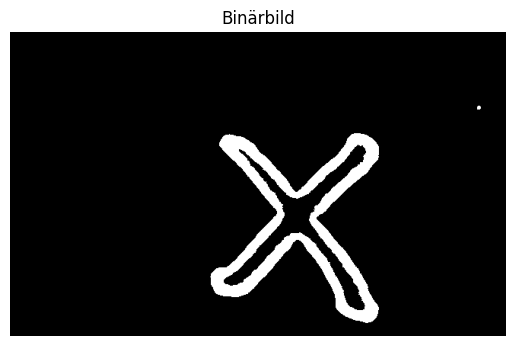

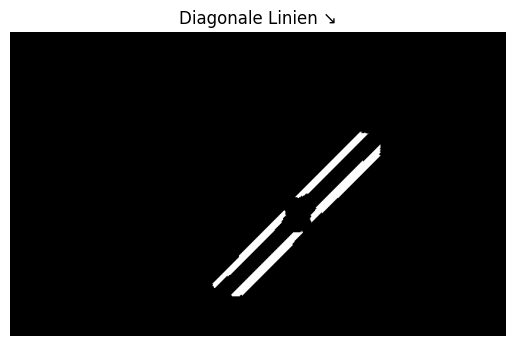

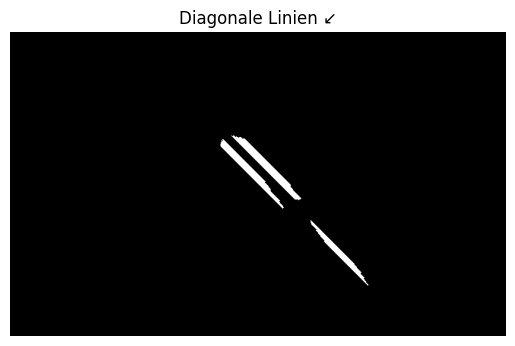

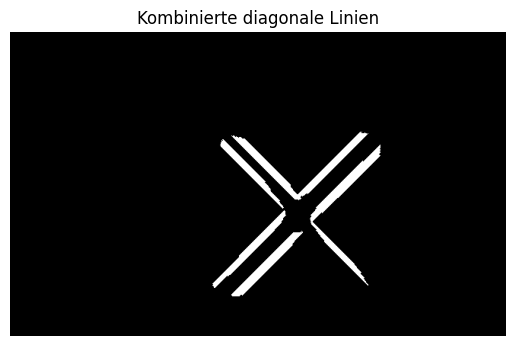

Anzahl diagonale Linien ↘: 16, ↙: 11


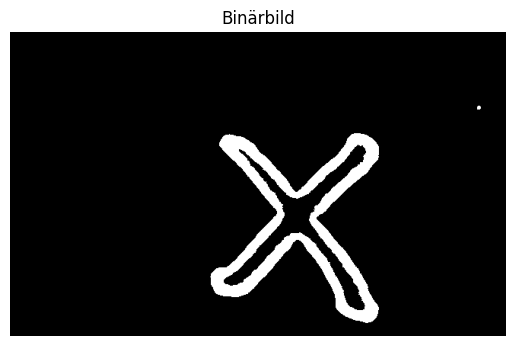

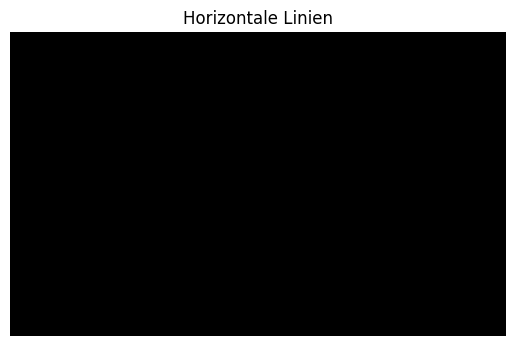

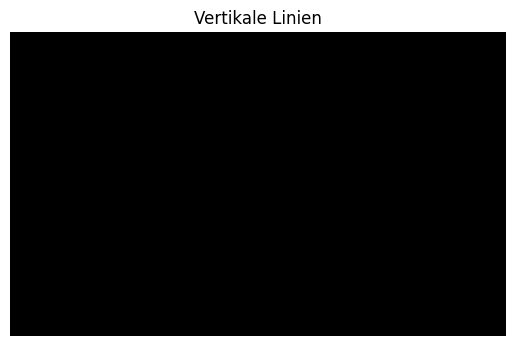

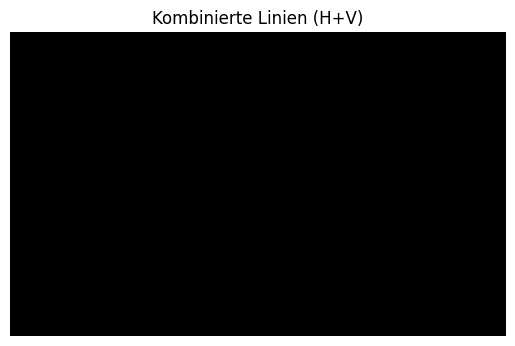

Anzahl horizontale Linien: 0, vertikale Linien: 0
X


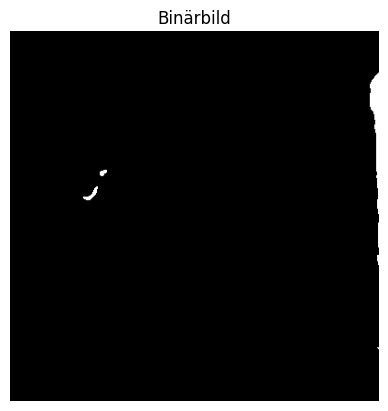

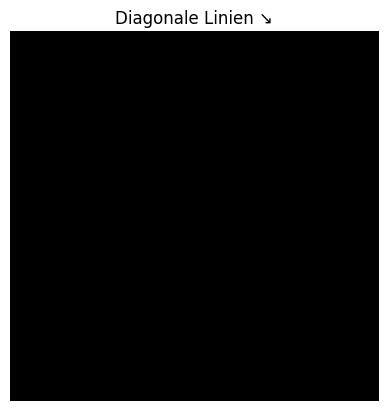

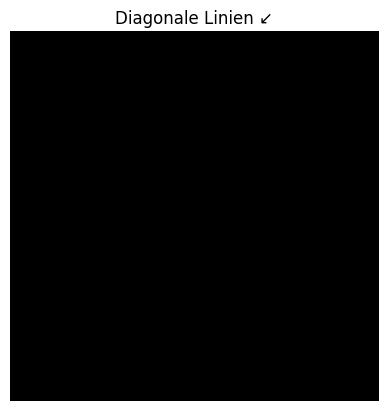

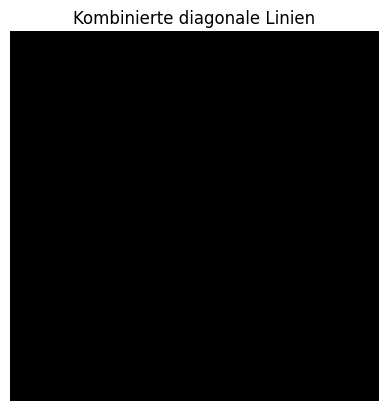

Anzahl diagonale Linien ↘: 0, ↙: 0


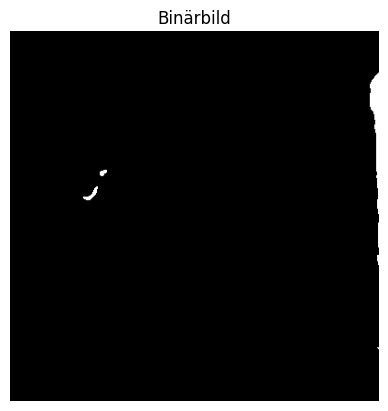

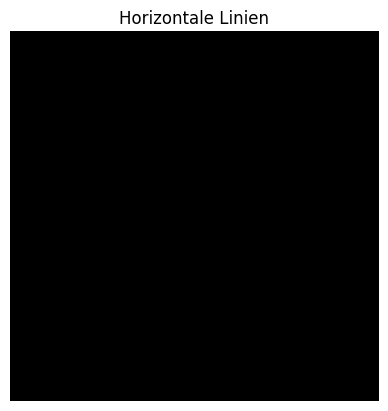

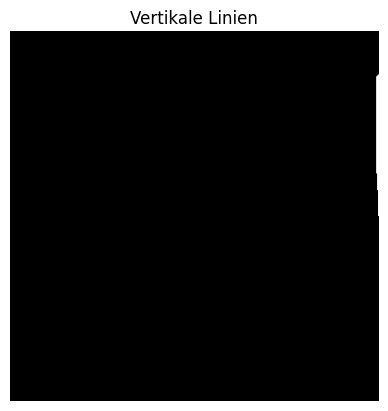

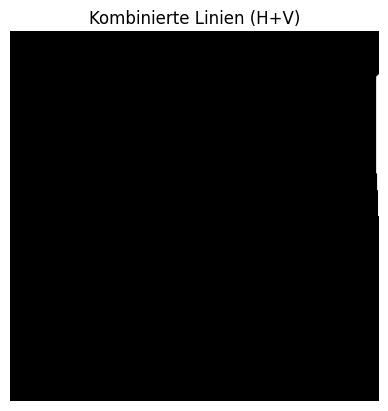

Anzahl horizontale Linien: 0, vertikale Linien: 1
Empty


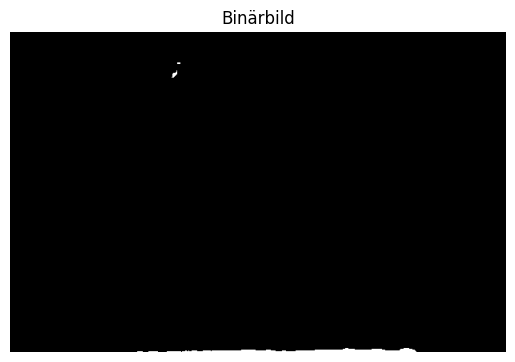

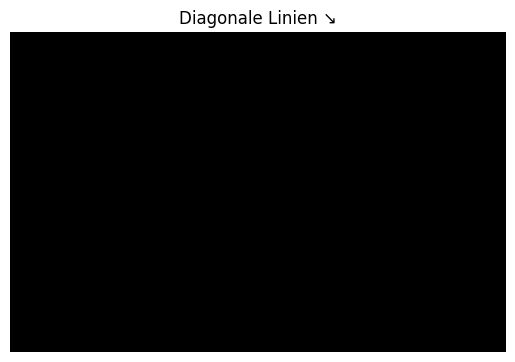

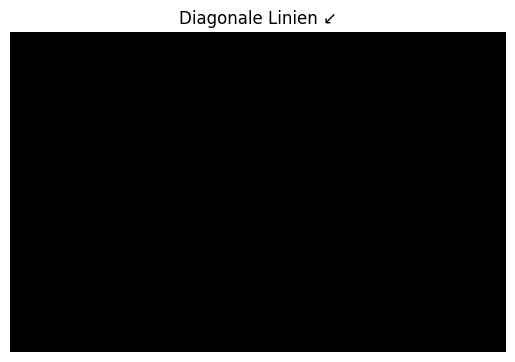

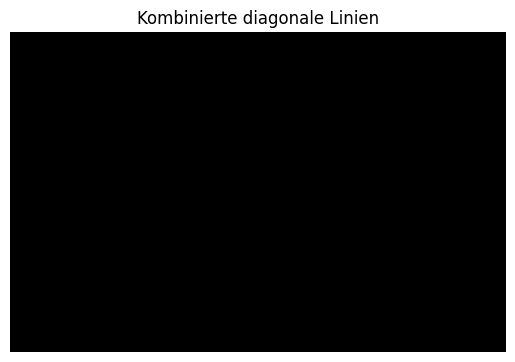

Anzahl diagonale Linien ↘: 0, ↙: 0


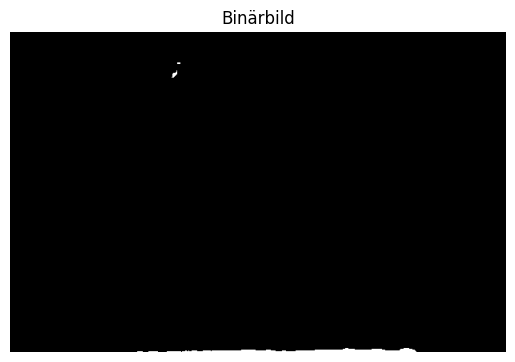

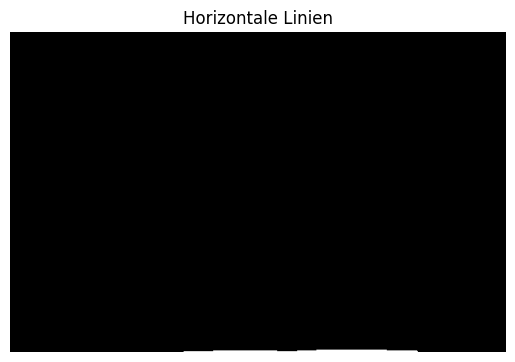

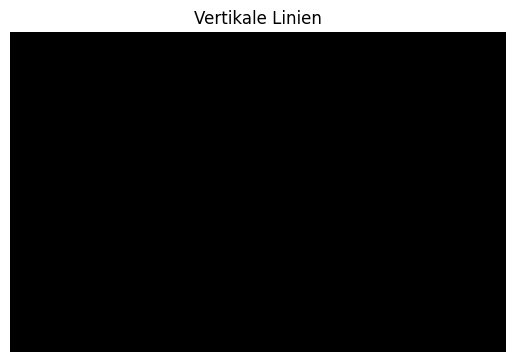

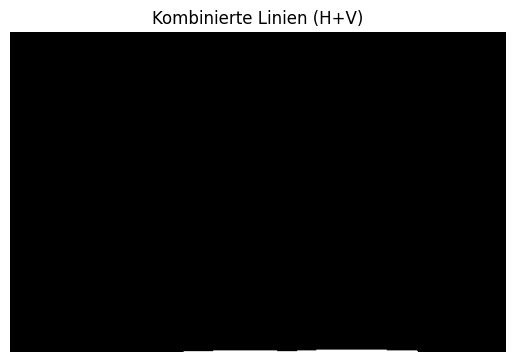

Anzahl horizontale Linien: 3, vertikale Linien: 0
Empty


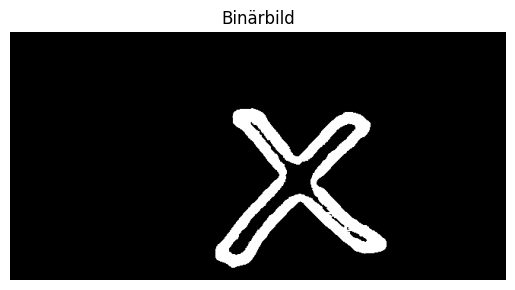

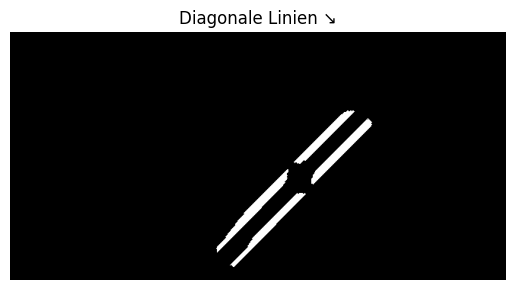

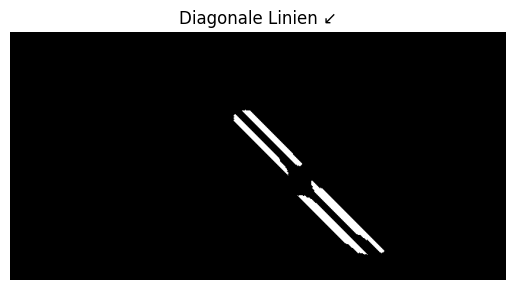

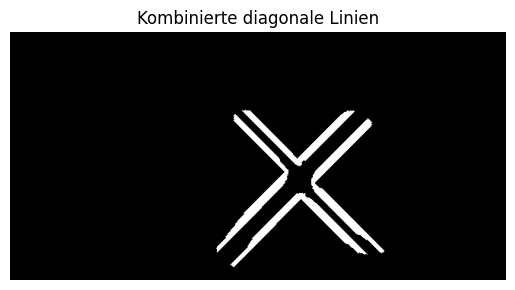

Anzahl diagonale Linien ↘: 15, ↙: 13


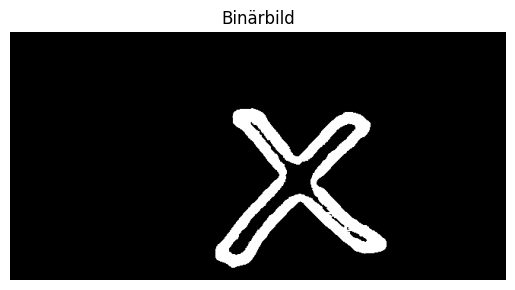

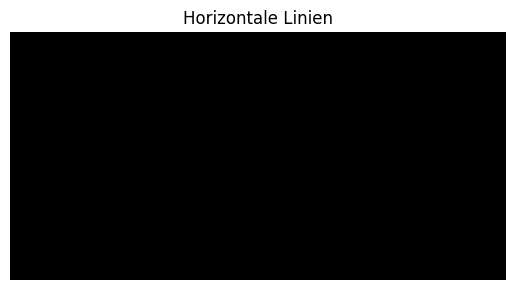

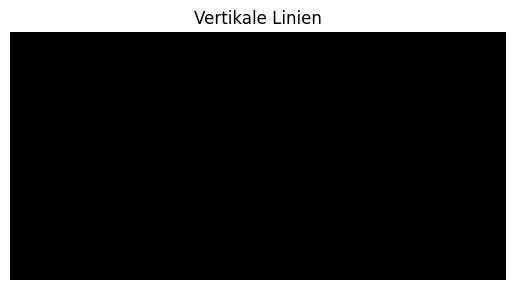

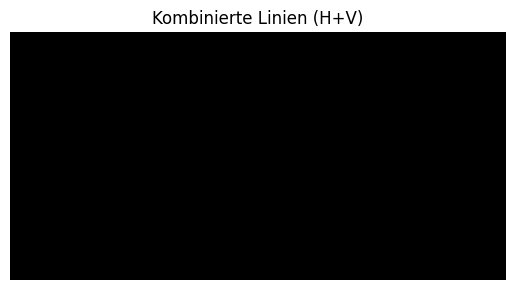

Anzahl horizontale Linien: 0, vertikale Linien: 0
X


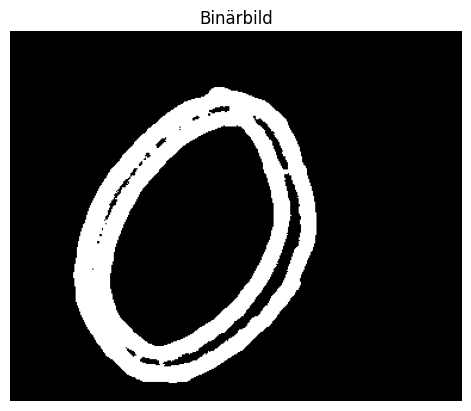

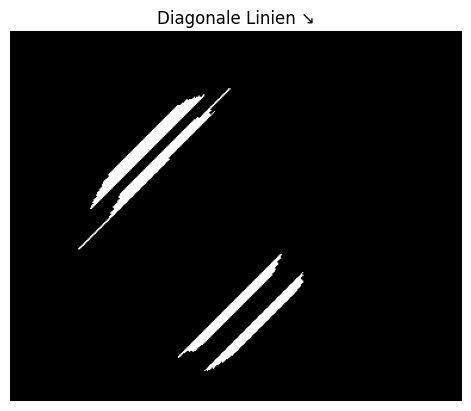

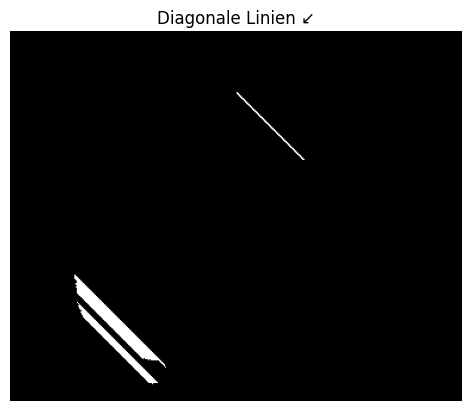

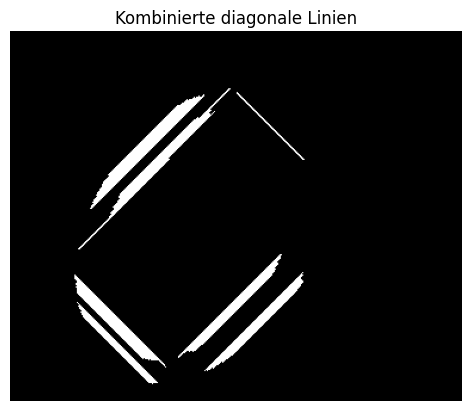

Anzahl diagonale Linien ↘: 15, ↙: 10


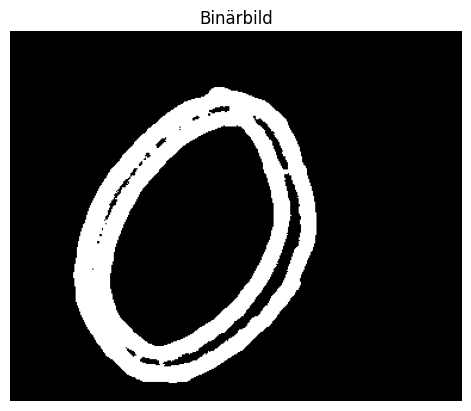

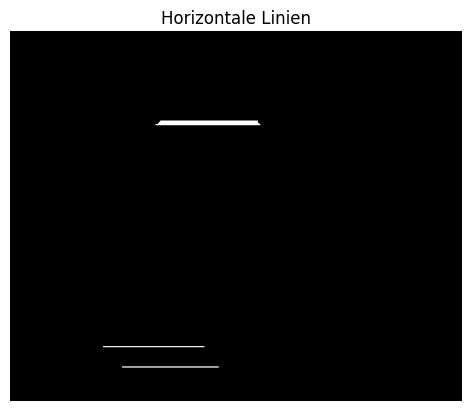

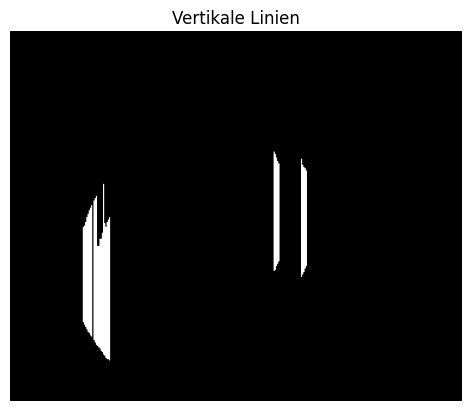

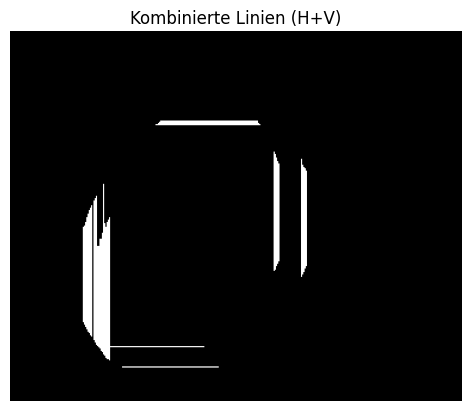

Anzahl horizontale Linien: 6, vertikale Linien: 11
O


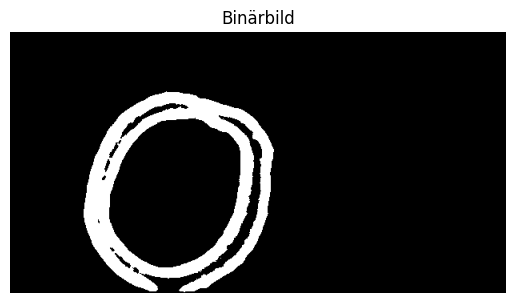

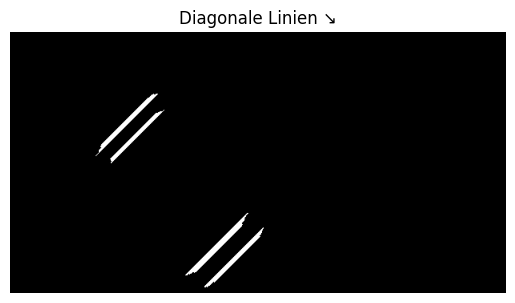

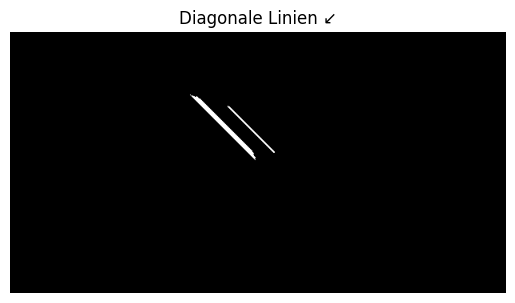

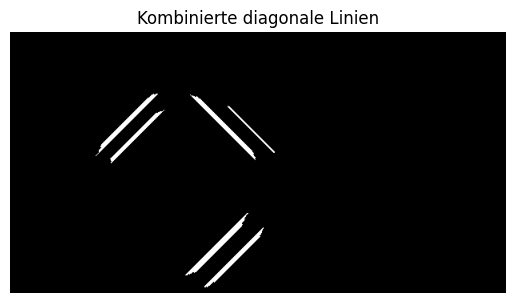

Anzahl diagonale Linien ↘: 14, ↙: 6


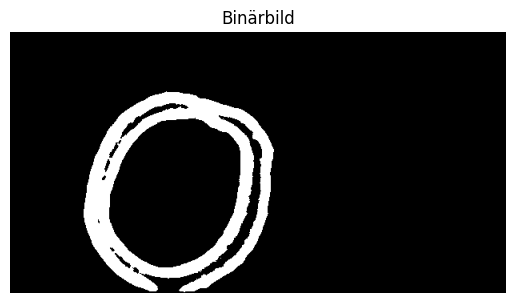

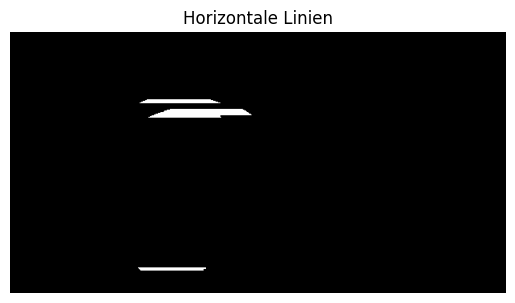

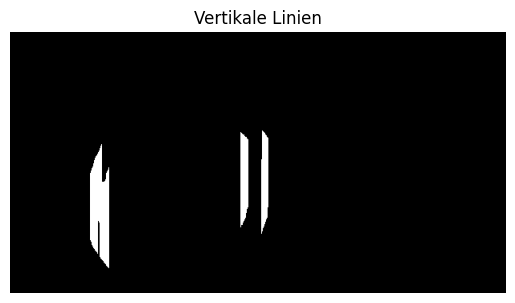

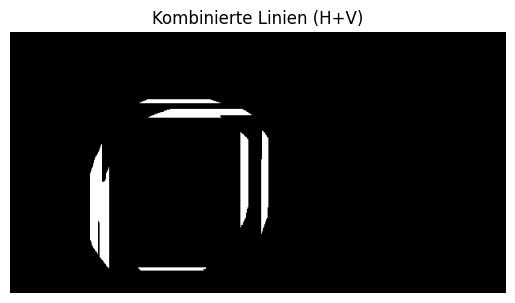

Anzahl horizontale Linien: 7, vertikale Linien: 7
O


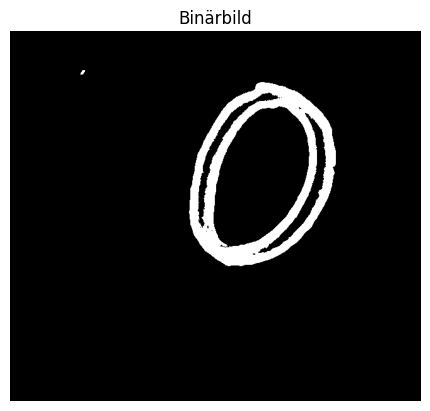

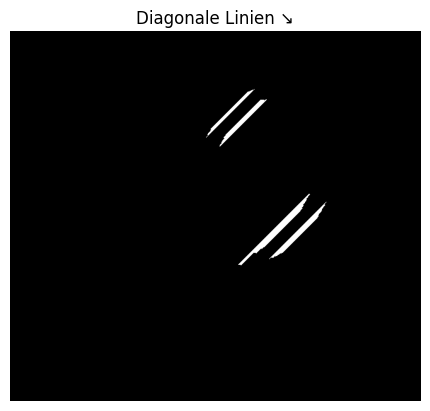

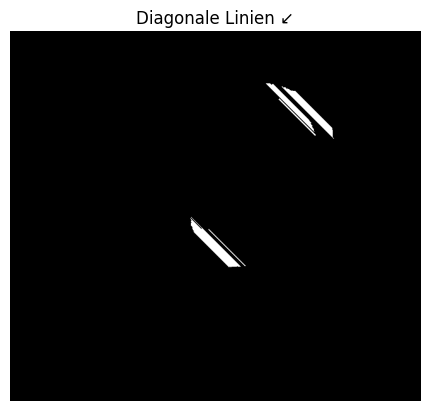

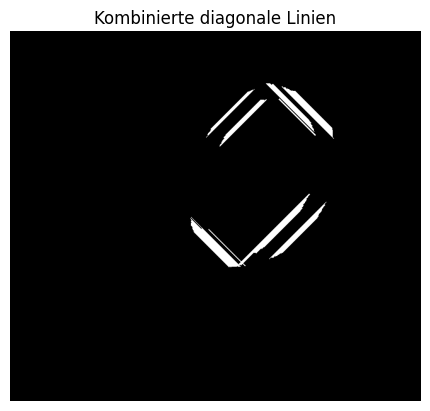

Anzahl diagonale Linien ↘: 13, ↙: 11


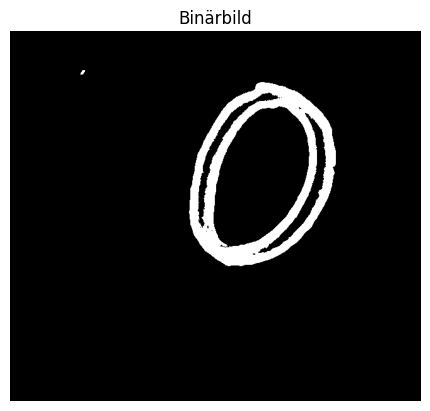

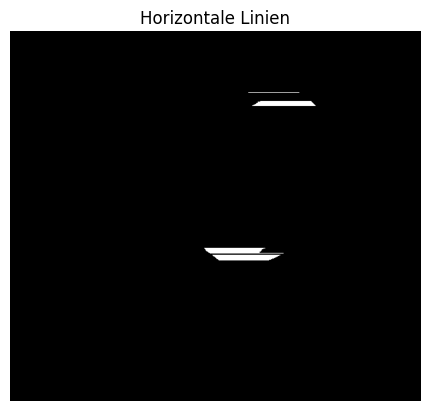

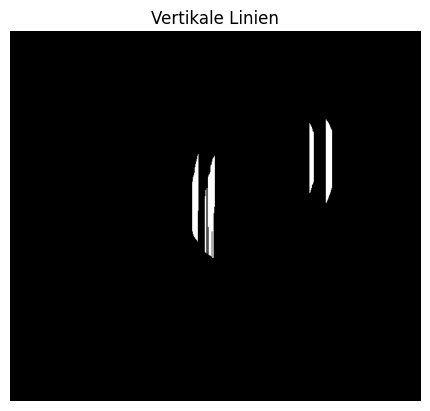

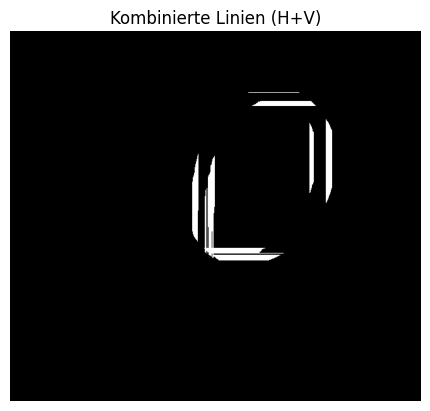

Anzahl horizontale Linien: 8, vertikale Linien: 11
O


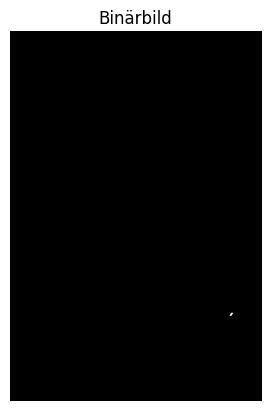

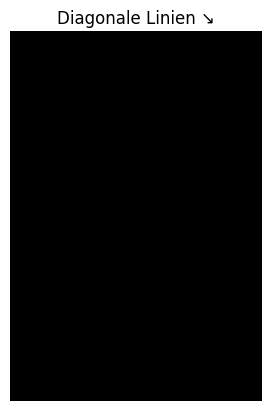

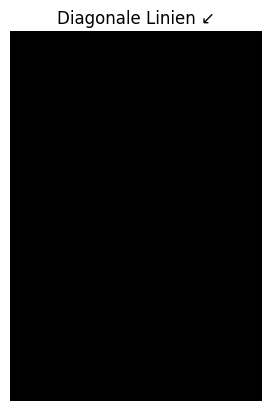

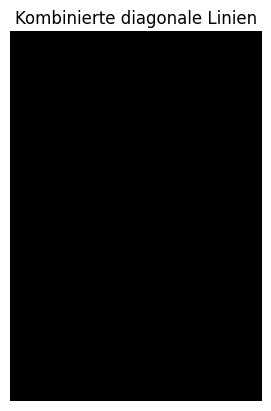

Anzahl diagonale Linien ↘: 0, ↙: 0


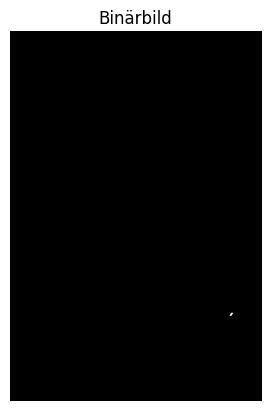

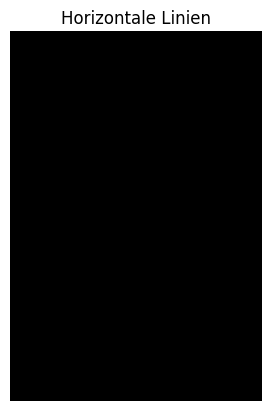

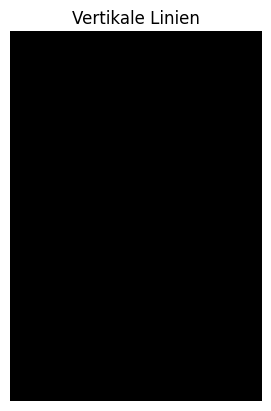

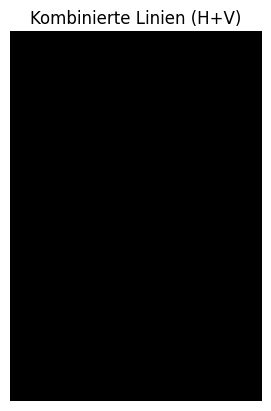

Anzahl horizontale Linien: 0, vertikale Linien: 0
Empty


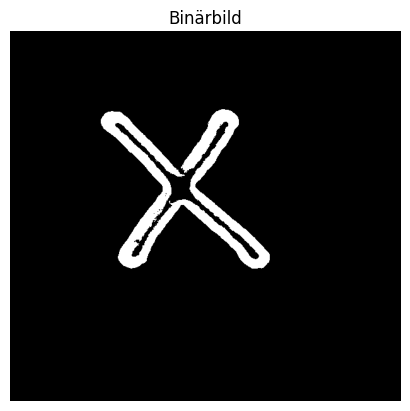

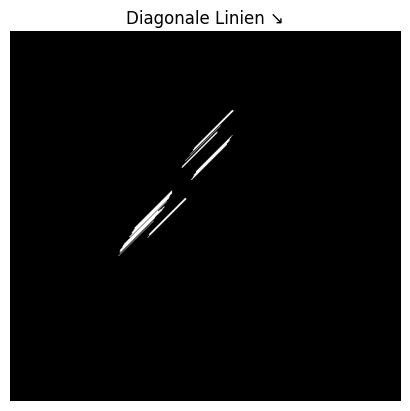

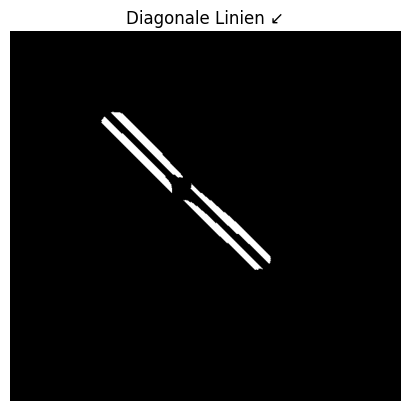

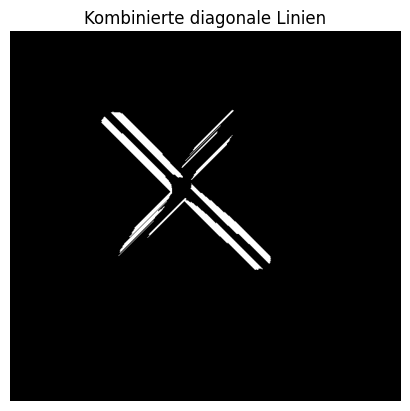

Anzahl diagonale Linien ↘: 17, ↙: 22


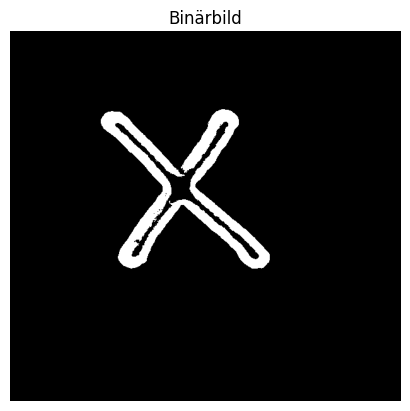

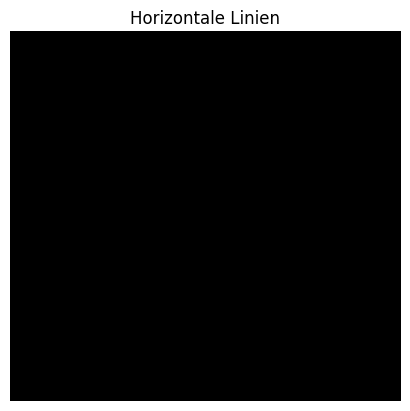

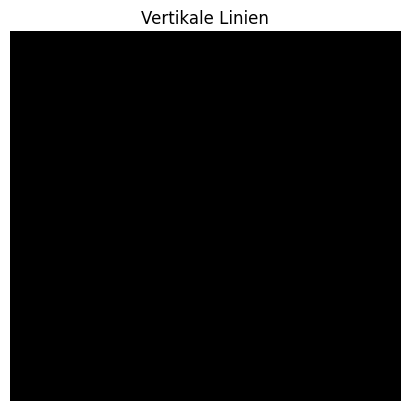

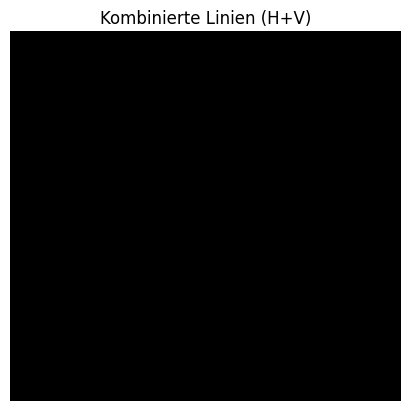

Anzahl horizontale Linien: 0, vertikale Linien: 0
X
Ergebnisse: ['X', 'Empty', 'Empty', 'X', 'O', 'O', 'O', 'Empty', 'X']


In [234]:
results = []
show = True
for img in field_bilder:
    x,y, num_d1, num_d2 = extract_diagonal_lines_from_image(img, show=show)
    v,w, num_h, num_v = extract_straight_lines_from_image(img, show=show)
    
    
    
    if num_d1 != 0 or num_d2 != 0:
        if num_h != 0 or num_v != 0:
            results.append("O")
            print("O")
        else:
            results.append("X")
            print("X")       
    elif (num_h and num_v) >= 4:
        results.append("O") 
    else:
        results.append("Empty")
        print("Empty")
    
print("Ergebnisse:", results)

In [231]:
def check_winner(results):
    winning_combinations = [
        (0, 1, 2),  # erste Reihe
        (3, 4, 5),  # zweite Reihe
        (6, 7, 8),  # dritte Reihe
        (0, 3, 6),  # erste Spalte
        (1, 4, 7),  # zweite Spalte
        (2, 5, 8),  # dritte Spalte
        (0, 4, 8),  # Diagonale von links oben nach rechts unten
        (2, 4, 6),  # Diagonale von rechts oben nach links unten
    ]
    winner = []
    for a, b, c in winning_combinations:
        if results[a] != 'empty' and results[a] == results[b] == results[c]:
            winner.append(results[a]) 
            
    match len(winner):
        case 0:
            return 'Keiner'    
        case 1:
            return winner[0]  # 'X' oder 'O'    
        case 2:
            return 'x & o'    


#results = ['x', 'x', 'x', 'o', 'o', 'o', 'o', 'empty', 'o']
print(f"{check_winner(results)} hat gewonnen")  # Ausgabe: 'x'

Keiner hat gewonnen
